<a href="https://colab.research.google.com/github/IngAS20/Maestria/blob/main/clasificador_vinilos_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lectura de los datos de entrenamiento

In [7]:
#Primer forma de leer nuestros datos, subiendo el archivo manualmente
!ls
!unzip leather_dataset.zip

drive  sample_data
unzip:  cannot find or open leather_dataset.zip, leather_dataset.zip.zip or leather_dataset.zip.ZIP.


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
#instalacion de la libreria one drive downloader
!pip install onedrivedownloader

In [10]:
!pip install torch
!pip install torchvision

In [11]:
from onedrivedownloader import download

path = "https://tecnube1-my.sharepoint.com/:u:/g/personal/sacalderon_itcr_ac_cr/Efak2SKuFNdJjxOiywHoV5gBQeK2SZEyTk0kQto7Kki3Eg?e=fs6AFI"
#Nombre del archivo
file_name = "leather_dataset.zip"
download(path, file_name, unzip = True, unzip_path = "./leather_dataset_2")


100%|██████████| 10.7M/10.7M [00:00<00:00, 65.4MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 1203/1203 [00:00<00:00, 4352.87it/s]


'./leather_dataset_2'

### Trabajo práctico: Varianza descriptor de textura en línea de producción de cuero.


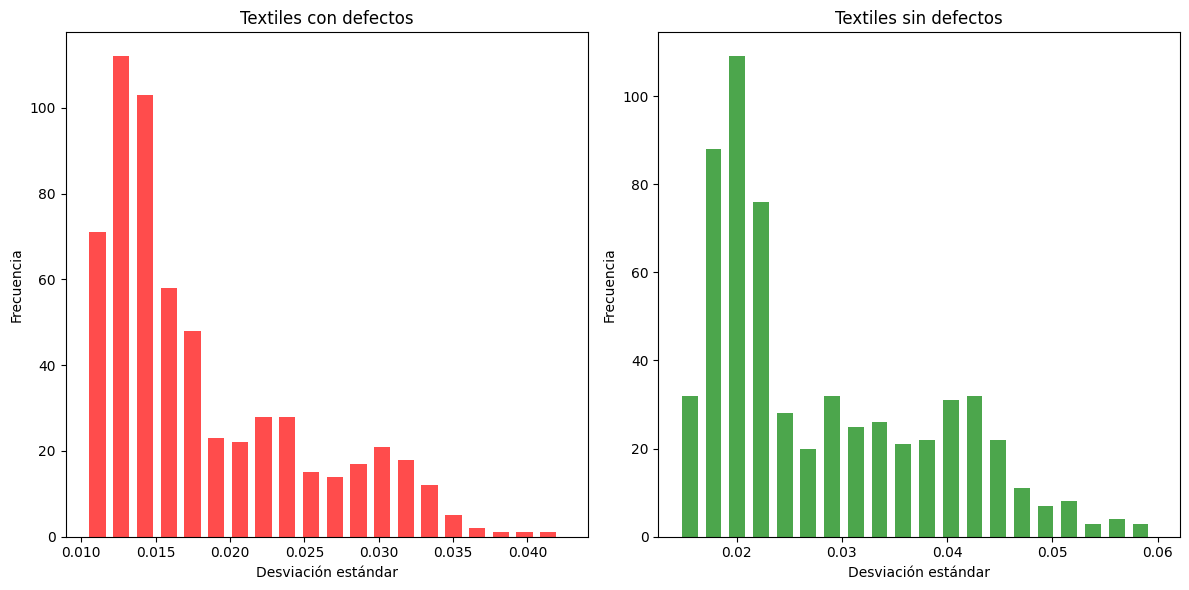

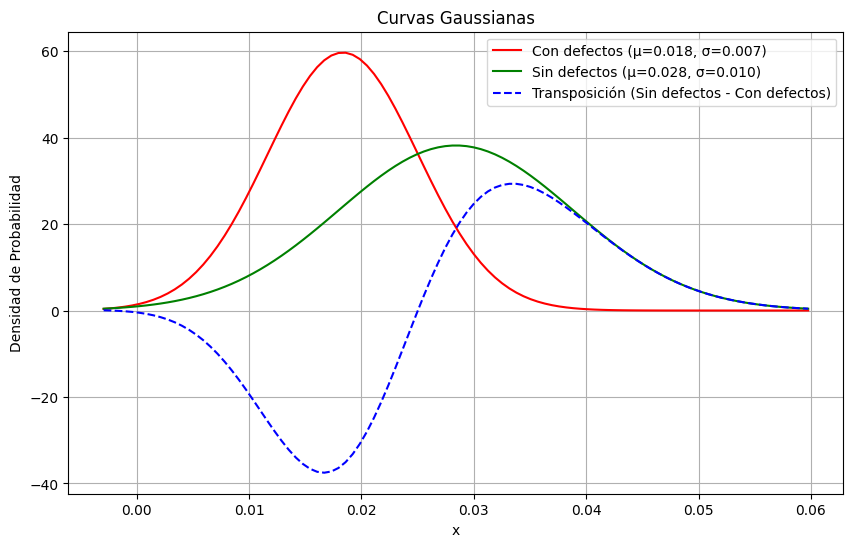

In [12]:
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
import matplotlib.pyplot as plt

# 1. Carga del dataset de imágenes
def cargar_dataset_entrenamiento(ruta_dataset):
    """
    Función que construye el cargador de imágenes en memoria.
    Parámetros:
        ruta_dataset: Ruta del dataset a cargar.
    Retorna:
        cargador_imagenes: Dataset cargado con transformaciones aplicadas.
    """
    transformaciones = transforms.Compose([
        transforms.Resize((223, 223)),  # Redimensiona las imágenes
        transforms.Grayscale(),        # Convierte a escala de grises
        transforms.ToTensor()          # Convierte la imagen en un tensor
    ])
    cargador_imagenes = ImageFolder(ruta_dataset, transform=transformaciones)
    return cargador_imagenes

# Ruta del dataset (modifica esta ruta según tu entorno)
ruta_dataset = "./leather_dataset_2/leather_dataset/"
cargador_imagenes = cargar_dataset_entrenamiento(ruta_dataset)

# 2. Cálculo de desviaciones estándar por categoría
def calcular_desviaciones_por_categoria(cargador, etiqueta):
    """
    Calcula las desviaciones estándar para una categoría específica.
    Parámetros:
        cargador: Dataset cargado.
        etiqueta: Índice de la etiqueta (0 para defectuoso, 1 para no defectuoso).
    Retorna:
        desviaciones: Lista de desviaciones estándar para la categoría.
    """
    desviaciones = []
    for imagen, lbl in cargador:
        if lbl == etiqueta:
            desviaciones.append(torch.std(imagen).item())  # Calcula desviación estándar
    return desviaciones

# Calcular desviaciones estándar para cada categoría
desviaciones_defectuosas = calcular_desviaciones_por_categoria(cargador_imagenes, 0)
desviaciones_no_defectuosas = calcular_desviaciones_por_categoria(cargador_imagenes, 1)

# 3. Graficar histogramas de desviaciones estándar
def graficar_histogramas(desviaciones_def, desviaciones_no_def):
    """
    Grafica los histogramas de las desviaciones estándar por categoría.
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(desviaciones_def, bins=20, alpha=0.7, color='red', width=0.0011)
    plt.title("Textiles con defectos")
    plt.xlabel("Desviación estándar")
    plt.ylabel("Frecuencia")

    plt.subplot(1, 2, 2)
    plt.hist(desviaciones_no_def, bins=20, alpha=0.7, color='green', width=0.0015)
    plt.title("Textiles sin defectos")
    plt.xlabel("Desviación estándar")
    plt.ylabel("Frecuencia")

    plt.tight_layout()
    plt.show()

# Graficar histogramas
graficar_histogramas(desviaciones_defectuosas, desviaciones_no_defectuosas)

# Convertir las desviaciones estándar en tensores
tensor_defectuosas = torch.tensor(desviaciones_defectuosas)
tensor_no_defectuosas = torch.tensor(desviaciones_no_defectuosas)

# 4. Calcular parámetros Gaussianos
mu_defectuosas = torch.mean(tensor_defectuosas)
sigma_defectuosas = torch.std(tensor_defectuosas)

mu_no_defectuosas = torch.mean(tensor_no_defectuosas)
sigma_no_defectuosas = torch.std(tensor_no_defectuosas)

# 5. Generar curvas Gaussianas
def calcular_curvas(mu1, sigma1, mu2, sigma2):
    """
    Calcula y grafica las curvas Gaussianas para dos distribuciones.
    Parámetros:
        mu1, sigma1: Media y desviación estándar de la primera distribución (con defectos).
        mu2, sigma2: Media y desviación estándar de la segunda distribución (sin defectos).
    """
    x = torch.linspace(min(mu1 - 3 * sigma1, mu2 - 3 * sigma2), max(mu1 + 3 * sigma1, mu2 + 3 * sigma2), 100)

    y1 = (1 / (sigma1 * torch.sqrt(torch.tensor(2 * torch.pi)))) * torch.exp(-0.5 * ((x - mu1) / sigma1) ** 2)
    y2 = (1 / (sigma2 * torch.sqrt(torch.tensor(2 * torch.pi)))) * torch.exp(-0.5 * ((x - mu2) / sigma2) ** 2)
    transposed_curve = y2 - y1

    # Graficar las curvas
    plt.figure(figsize=(10, 6))
    plt.plot(x.numpy(), y1.numpy(), label=f"Con defectos (μ={mu1.item():.3f}, σ={sigma1.item():.3f})", color='red')
    plt.plot(x.numpy(), y2.numpy(), label=f"Sin defectos (μ={mu2.item():.3f}, σ={sigma2.item():.3f})", color='green')
    plt.plot(x.numpy(), transposed_curve.numpy(), label="Transposición (Sin defectos - Con defectos)", color='blue', linestyle='dashed')
    plt.xlabel("x")
    plt.ylabel("Densidad de Probabilidad")
    plt.title("Curvas Gaussianas")
    plt.legend()
    plt.grid(True)
    plt.show()

# Graficar
calcular_curvas(mu_defectuosas, sigma_defectuosas, mu_no_defectuosas, sigma_no_defectuosas)
